# long-short-portfolio

On the first trading day of every month, rebalance portfolio to given percentages.  One of the positions is a short position.

In [1]:
import datetime

import matplotlib.pyplot as plt
import pandas as pd

import pinkfish as pf

# Format price data.
pd.options.display.float_format = '{:0.2f}'.format

%matplotlib inline

In [2]:
# Set size of inline plots.
'''note: rcParams can't be in same cell as import matplotlib
   or %matplotlib inline
   
   %matplotlib notebook: will lead to interactive plots embedded within
   the notebook, you can zoom and resize the figure
   
   %matplotlib inline: only draw static images in the notebook
'''
plt.rcParams["figure.figsize"] = (10, 7)

Define Portfolios

Note: By using an underscore, we can use a symbol multiple times in a portfolio under a different name.  This is useful when you want to have a short and long position at the same time.

In [3]:
portfolio_option = {'SPY': 0.50, 'TLT': 0.30, 'GLD': 0.10, 'TLT_SHRT': 0.10}

directions = {'SPY': pf.Direction.LONG, 'TLT': pf.Direction.LONG,
              'GLD': pf.Direction.LONG, 'TLT_SHRT' : pf.Direction.SHORT}

Some global data

In [4]:
symbols = list(portfolio_option.keys())
capital = 10000
start = datetime.datetime(1900, 1, 1)
end = datetime.datetime.now()

In [5]:
options = {
    'use_adj' : True,
    'use_cache' : True,
}
options

{'use_adj': True, 'use_cache': True}

In [6]:
# Fetch timeseries
portfolio = pf.Portfolio()
ts = portfolio.fetch_timeseries(symbols, start, end, fields=['close'],
                                use_cache=options['use_cache'], use_adj=options['use_adj'])
# Add calendar columns
ts = portfolio.calendar(ts)

# Finalize timeseries
ts, start = portfolio.finalize_timeseries(ts, start)

# Init trade logs
portfolio.init_trade_logs(ts)

In [7]:
pf.TradeLog.cash = capital

# Trading algorithm
for i, row in enumerate(ts.itertuples()):

    end_flag = pf.is_last_row(ts, i)
    
    # Rebalance on the first trading day of each month
    if row.first_dotm or end_flag:

        portfolio.print_holdings(row)
        
        # If last row, then zero out all weights.  Otherwise use portfolio_option weights.
        weights = portfolio_option if not end_flag else pf.set_dict_values(portfolio_option, 0)
        
        # Adjust weights of all symbols in portfolio
        portfolio.adjust_percents(row, weights, field='close', directions=directions)

    # Record daily balance.
    portfolio.record_daily_balance(row)

2004-12-01 SPY:  0 GLD:  0 TLT:  0 TLT_SHRT:  0 cash: 10,000.00 total: 10,000.00
2005-01-03 SPY: 61 GLD: 22 TLT: 64 TLT_SHRT: 21 cash:    83.72 total: 10,077.08
2005-02-01 SPY: 61 GLD: 23 TLT: 63 TLT_SHRT: 21 cash:    88.58 total: 10,061.74
2005-03-01 SPY: 61 GLD: 23 TLT: 61 TLT_SHRT: 20 cash:   230.92 total: 10,157.35
2005-04-01 SPY: 61 GLD: 23 TLT: 62 TLT_SHRT: 20 cash:   182.18 total: 10,001.97
2005-05-02 SPY: 61 GLD: 23 TLT: 61 TLT_SHRT: 20 cash:   230.91 total: 10,034.45
2005-06-01 SPY: 62 GLD: 23 TLT: 59 TLT_SHRT: 19 cash:   294.12 total: 10,267.79
2005-07-01 SPY: 61 GLD: 24 TLT: 58 TLT_SHRT: 19 cash:   388.26 total: 10,269.35
2005-08-01 SPY: 62 GLD: 24 TLT: 58 TLT_SHRT: 19 cash:   305.57 total: 10,404.02
2005-09-01 SPY: 60 GLD: 24 TLT: 61 TLT_SHRT: 20 cash:   272.13 total: 10,449.89
2005-10-03 SPY: 61 GLD: 23 TLT: 59 TLT_SHRT: 19 cash:   377.84 total: 10,447.23
2005-11-01 SPY: 61 GLD: 22 TLT: 61 TLT_SHRT: 20 cash:   271.64 total: 10,309.39
2005-12-01 SPY: 61 GLD: 22 TLT: 61 TLT_

In [8]:
# Get logs
rlog, tlog, dbal = portfolio.get_logs()

In [9]:
rlog.head(10)

,date,seq_num,price,shares,entry_exit,direction,symbol
0,2004-12-01,0,45.38,22,entry,LONG,GLD
0,2004-12-01,1,46.47,21,entry,SHRT,TLT_SHRT
0,2004-12-01,2,46.47,64,entry,LONG,TLT
0,2004-12-01,3,81.45,61,entry,LONG,SPY
1,2005-01-03,4,47.88,1,exit,LONG,TLT
1,2005-01-03,5,43.02,1,entry,LONG,GLD
2,2005-02-01,6,49.40,2,exit,LONG,TLT
1,2005-02-01,7,49.40,1,exit,SHRT,TLT_SHRT
3,2005-03-01,8,48.74,1,entry,LONG,TLT
4,2005-04-01,9,48.70,1,exit,LONG,TLT


In [10]:
tlog.tail(100)

,entry_date,entry_price,exit_date,exit_price,pl_points,pl_cash,qty,cumul_total,direction,symbol
67,2018-02-01,103.00,2024-08-22,97.89,5.11,5.11,1,23551.51,SHRT,TLT_SHRT
123,2018-03-01,239.04,2024-08-22,552.66,313.62,313.62,1,23865.13,LONG,SPY
124,2018-04-02,230.82,2024-08-22,552.66,321.83,643.67,2,24508.80,LONG,SPY
124,2018-05-01,101.69,2024-08-22,97.89,-3.80,-7.61,2,24501.19,LONG,TLT
68,2018-05-01,101.69,2024-08-22,97.89,3.80,3.80,1,24505.00,SHRT,TLT_SHRT
...,...,...,...,...,...,...,...,...,...,...
161,2024-04-01,91.32,2024-08-22,97.89,6.57,32.86,5,32074.01,LONG,TLT
162,2024-05-01,87.69,2024-08-22,97.89,10.20,30.61,3,32104.62,LONG,TLT
81,2024-07-01,215.57,2024-08-22,228.61,13.04,13.04,1,32117.66,LONG,GLD
163,2024-07-01,89.61,2024-08-22,97.89,8.28,33.11,4,32150.78,LONG,TLT


In [11]:
dbal.tail()

,high,low,close,shares,cash,leverage,state
date,,,,,,,
2024-08-16,45694.14,45694.14,45694.14,245,68.88,1.00,-
2024-08-19,45940.76,45940.76,45940.76,245,68.88,1.00,-
2024-08-20,45995.63,45995.63,45995.63,245,68.88,1.00,-
2024-08-21,46071.80,46071.80,46071.80,245,68.88,1.00,-
2024-08-22,42155.94,42155.94,42155.94,0,42155.94,1.00,X


In [12]:
stats = pf.stats(ts, tlog, dbal, capital)
pf.print_full(stats)

start                                                  2004-11-18
end                                                    2024-08-22
beginning_balance                                           10000
ending_balance                                           42155.94
total_net_profit                                         32155.94
gross_profit                                             37092.86
gross_loss                                               -4936.93
profit_factor                                                7.51
return_on_initial_capital                                  321.56
annual_return_rate                                           7.55
trading_period                           19 years 9 months 4 days
pct_time_in_market                                          99.84
margin                                                          1
avg_leverage                                                 1.00
max_leverage                                                 1.00
min_levera

,cumul_total,weight,pct_cumul_total,relative_performance
SPY,"$26,551.50",0.50,0.83,1.65
GLD,"$3,632.55",0.10,0.11,1.13
TLT,"$2,920.53",0.30,0.09,0.30
TLT_SHRT,-$948.65,0.10,-0.03,-0.30
TOTAL,"$32,155.94",1.00,1.00,1.00


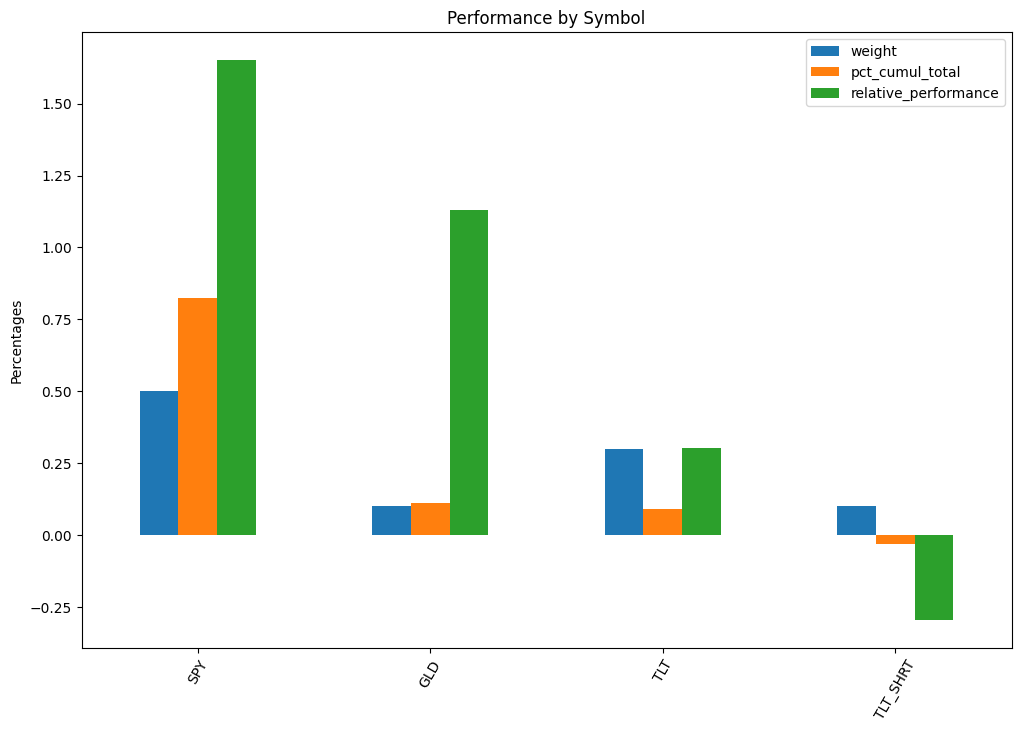

In [13]:
totals = portfolio.performance_per_symbol(portfolio_option)
totals

In [14]:
benchmark = pf.Benchmark('SPY', capital, start, end, use_adj=True)
benchmark.run()

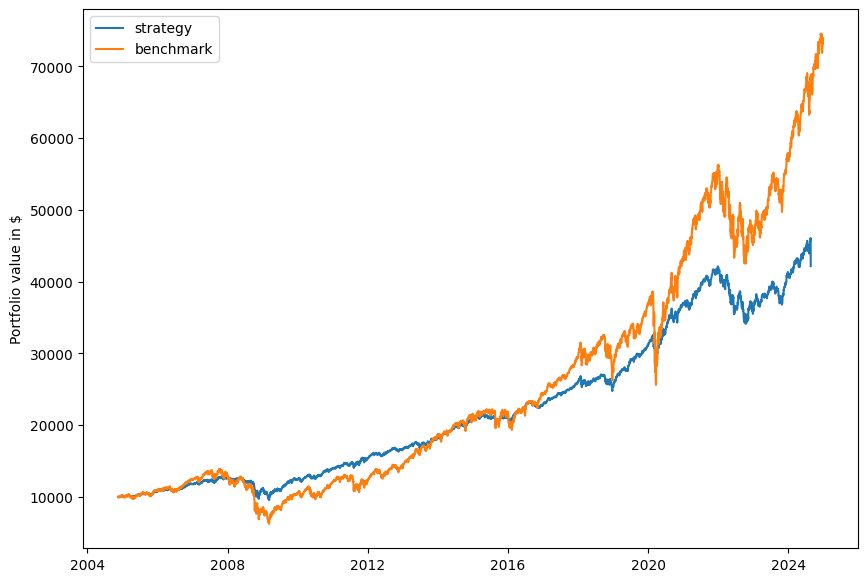

In [15]:
pf.plot_equity_curve(dbal, benchmark=benchmark.dbal)

In [16]:
df = pf.summary(stats, benchmark.stats, metrics=pf.currency_metrics)
df

,strategy,benchmark
beginning_balance,"$10,000.00","$10,000.00"
ending_balance,"$42,155.94","$73,209.64"
total_net_profit,"$32,155.94","$63,209.64"
gross_profit,"$37,092.86","$63,209.64"
gross_loss,"-$4,936.93",$0.00


,strategy,benchmark
annual_return_rate,7.55,10.41
max_closed_out_drawdown,-25.59,-55.10
annualized_return_over_max_drawdown,0.30,0.19
best_month,14.07,23.53
worst_month,-15.73,-30.97
sharpe_ratio,0.84,0.62
sortino_ratio,1.02,0.75
monthly_std,2.35,4.48
annual_std,8.28,16.42


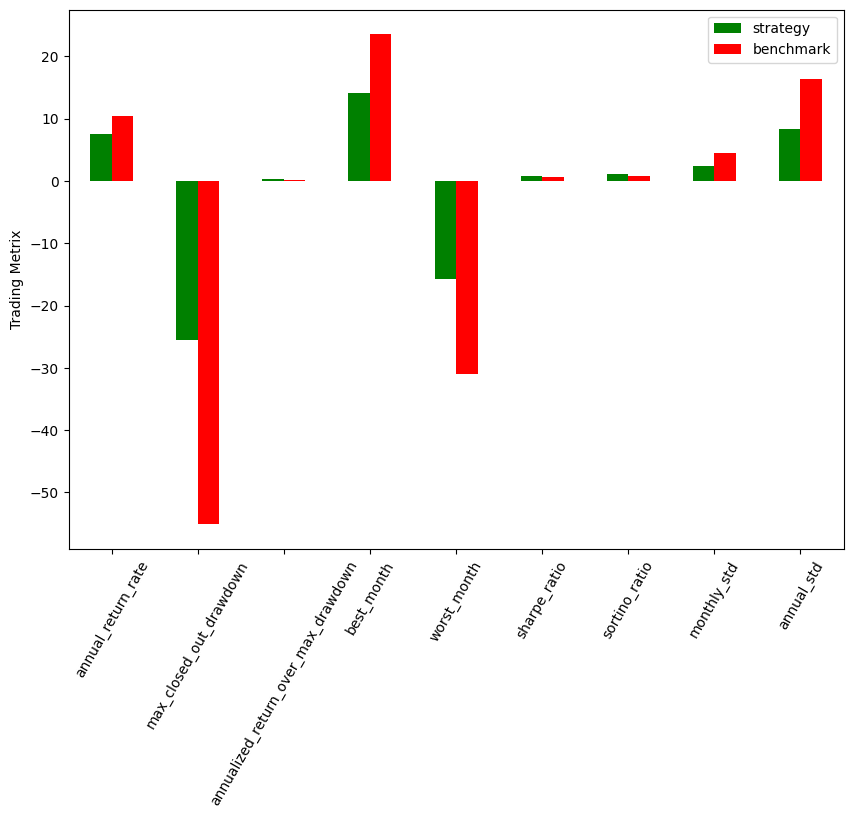

In [17]:
df = pf.plot_bar_graph(stats, benchmark.stats)
df